In [2]:
import pygris
import matplotlib.pyplot
from matplotlib_map_utils.core.north_arrow import north_arrow
from matplotlib_map_utils.core.scale_bar import scale_bar, ScaleBar

In [3]:
# This is just a function to create a new, blank map with matplotlib, with our default settings
def new_map(rows=1, cols=1, figsize=(5,5), dpi=150, ticks=False):
    # Creating the plot(s)
    fig, ax = matplotlib.pyplot.subplots(rows,cols, figsize=figsize, dpi=dpi)
    # Turning off the x and y axis ticks
    if ticks==False:
        if rows > 1 or cols > 1:
            for a in ax.flatten():
                a.set_xticks([])
                a.set_yticks([])
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    # Returning the fig and ax
    return fig, ax

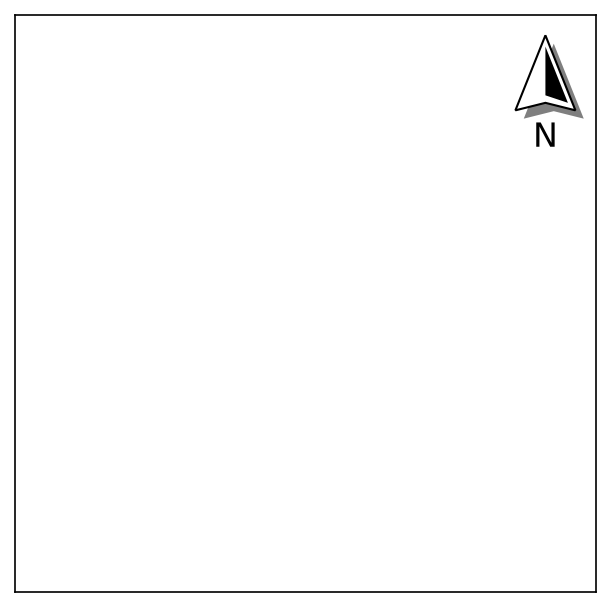

In [19]:
# README north arrow plot

# Setting up a plot
fig, ax = new_map()
# Adding a north arrow to the upper-right corner of the axis, without any rotation (see Rotation under Formatting Components for details)
north_arrow(ax=ax, location="upper right", rotation={"degrees":0})

matplotlib.pyplot.savefig("./readme_northarrow.png", bbox_inches="tight")

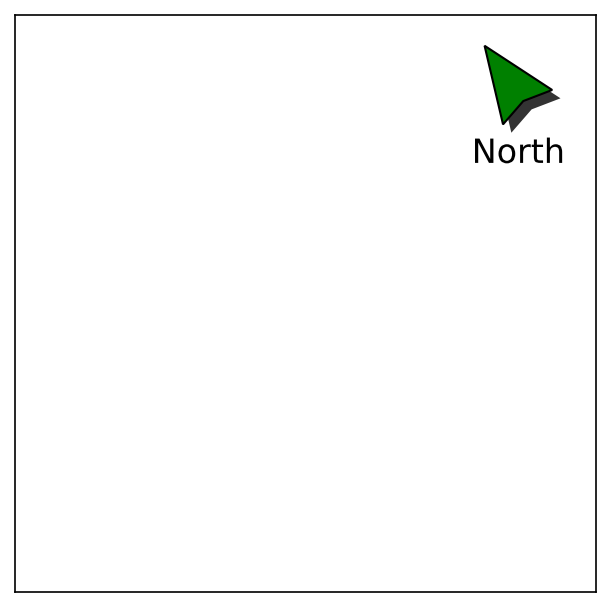

In [5]:
# README north arrow plot

# Setting up a plot
fig, ax = new_map()
# Adding a more customized north arrow
north_arrow(
    ax,
    location = "upper right", # accepts a valid string from the list of locations
    scale = 0.5, # accepts a valid positive float or integer
    # each of the follow accepts arguments from a customized style dictionary
    base = {"facecolor":"green"},
    fancy = False,
    label = {"text":"North"},
    shadow = {"alpha":0.8},
    pack = {"sep":6},
    aob = {"pad":1},
    rotation = {"degrees": 35})

matplotlib.pyplot.savefig("./readme_northarrow_customization.png", bbox_inches="tight")

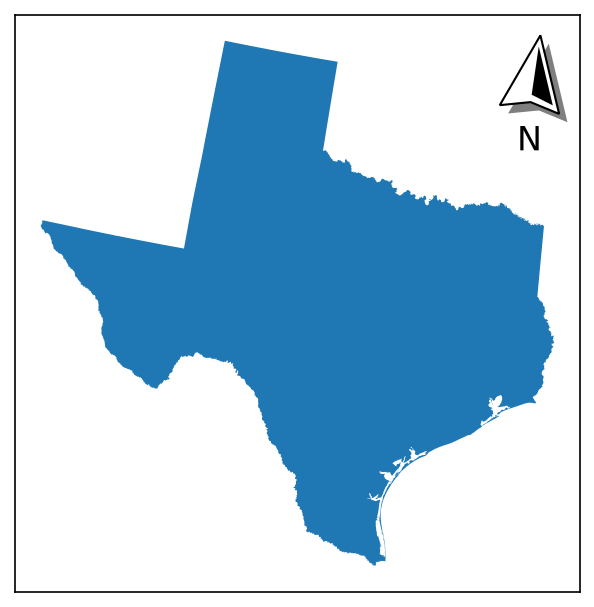

In [18]:
# README north arrow rotation
states = pygris.states(cb=True, year=2022, cache=False).to_crs(3857)
# Setting up a plot
fig, ax = new_map()
# Plotting a state (Texas)
states.query("NAME=='Texas'").to_crs(3520).plot(ax=ax)
# Adding a north arrow to the upper-right corner of the axis, without any rotation (see Rotation under Formatting Components for details)
north_arrow(ax=ax, location="upper right", rotation={"crs":3520, "reference":"center"})

matplotlib.pyplot.savefig("./readme_northarrow_rotation.png", bbox_inches="tight")

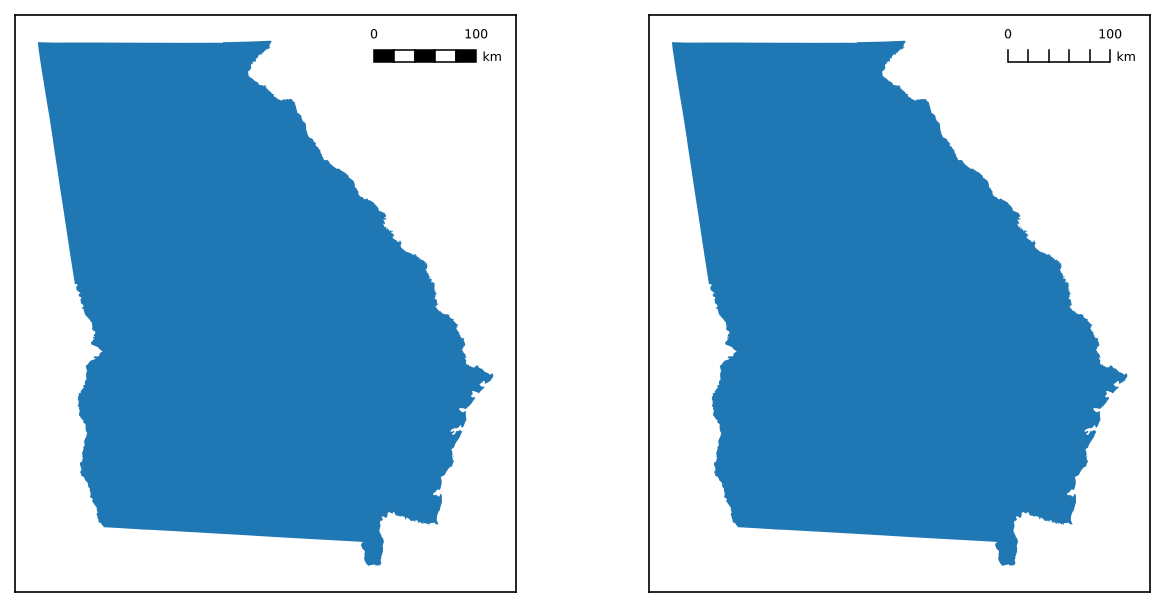

In [17]:
# README scalebars
# Setting up a plot
fig, ax = new_map(1,2, figsize=(10,5))
# Changing the size
ScaleBar.set_size("sm")
# Plotting a state (Georgia)
states.query("NAME=='Georgia'").to_crs(3520).plot(ax=ax[0])
states.query("NAME=='Georgia'").to_crs(3520).plot(ax=ax[1])
# Adding a scale bar to the upper-right corner of the axis, in the same projection as whatever geodata you plotted
scale_bar(ax=ax[0], location="upper right", style="boxes", bar={"projection":3520})
scale_bar(ax=ax[1], location="upper right", style="ticks", bar={"projection":3520})

matplotlib.pyplot.savefig("./readme_scalebar.png", bbox_inches="tight")

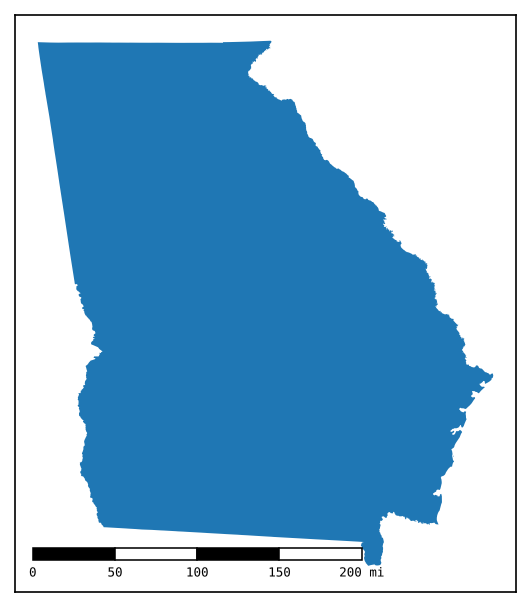

In [16]:
# README scalebars with customization
# Setting up a plot
fig, ax = new_map(1,1, figsize=(5,5))
# Plotting a state (Georgia)
states.query("NAME=='Georgia'").to_crs(3520).plot(ax=ax)
# Adding a scale bar to the upper-right corner of the axis, in the same projection as whatever geodata you plotted
scale_bar(ax=ax, location="lower left", style="boxes",
          # each of the follow accepts arguments from a customized style dictionary
            bar = {"projection":3520, "unit":"mi", "length":1.75}, # converting the units to miles, and changing the length of the bar (in inches)
            labels = {"style":"major", "loc":"below"}, # placing a label on each major division, and moving them below the bar
            units = {"loc":"text"}, # changing the location of the units text to the major division labels
            text = {"fontfamily":"monospace"}, # changing the font family of all the text to monospace)
        )

matplotlib.pyplot.savefig("./readme_scalebar_customization.png", bbox_inches="tight")